# Loading Libraries

In [1]:
# Pandas & Numpy
import pandas as pd
import numpy as np 

# Visualization
import seaborn as sns 
from matplotlib import pyplot as plt 

# Tensorflow
import tensorflow as tf
from tensorflow import keras 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
    ndcg_at_k,
    map_at_k
)
from sklearn.metrics import accuracy_score 

# Recomender Utilities
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.split_utils import min_rating_filter_pandas

# Multi VAE Model
from recommenders.models.vae.multinomial_vae import Mult_VAE

# System & OS
import sys
import os

# Turn of Warnings for Readability 
import warnings
warnings.filterwarnings("ignore")

# Import & Read Dataset

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/rec_sys_binary_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/rec_sys_binary_test.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (137627, 3)
Shape of Test: 	 (34505, 3)


In [4]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3011
Unique Users in Test: 3011
Unique Items in Train: 2307
Unique Items in Test: 2307


In [5]:
# Concatenate both Dataset again for further Data Preparation
df = pd.concat([train, test], axis=0)

In [6]:
# Change name of columns 
df = df.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})
df.columns

Index(['itemID', 'userID', 'rating'], dtype='object')

# Data Filtering 

In [7]:
# Binarize the data (only keep ratings >= 0.5)
df_preferred = df[df['rating'] > 0.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 0.5]


# Head of df_preferred
df_preferred.head(10)

(172132, 3)


,itemID,userID,rating
159681,84625C,12347,1
99374,22771,12347,1
126306,23171,12347,1
137181,23297,12347,1
165161,84997B,12347,1
150628,51014C,12347,1
95802,22729,12347,1
78585,22550,12347,1
138867,23308,12347,1
2771,20665,12347,1


In [8]:
# Keep users who clicked on at least 5 items
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [9]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d interactions between %d users and %d items (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 172132 interactions between 3011 users and 2307 items (sparsity: 2.478%)


# Split Data

In [10]:
unique_users = sorted(df.userID.unique())
np.random.seed(1)
unique_users = np.random.permutation(unique_users)

In [11]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

# Calculate 20% of unique Users  
users_20_per = round((n_users * 0.2), 0)

train_users = unique_users[:(n_users - 602 * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - 602 * 2) : (n_users - 602)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - 602):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 3011

Number of training users: 1807

Number of validation users: 602

Number of test users: 602


In [12]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])


Number of training observations:  104211

Number of validation observations:  34826

Number of test observations:  33095


In [13]:
# Obtain list of unique items used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique items that consumed in training set", unique_train_items.size)

Number of unique items that consumed in training set 2307


In [14]:
# For validation set keep only items that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies items used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  34826

Number of test observations after filtering:  33095


In [15]:
test_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0])

0.19226523830548647

# Click Matrix Generation

In [16]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [17]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(1807, 2307)
(602, 2307)
(602, 2307)


In [18]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=1)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=1)

In [19]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=0.5)
val_data = binarize(a=val_data, threshold=0.5)
test_data = binarize(a=test_data, threshold=0.5)

In [20]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=0.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=0.5)

In [21]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0.5)

# Shapes & Dimensions after Data Preparation

In [22]:
np.unique(train_data)

array([0., 1.])

In [23]:
np.unique(val_data)

array([0., 1.])

In [24]:
np.unique(val_data_tr)

array([0., 1.])

In [25]:
np.unique(val_data_te_ratings)

array([0, 1])

In [26]:
np.unique(test_data_tr)

array([0., 1.])

In [27]:
np.unique(test_data_te_ratings)

array([0, 1])

# Hyperparameter Tuning

In [28]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [29]:
from tempfile import TemporaryDirectory

tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "svae_weights.hdf5")

In [32]:
# Set up Parameters
intermediate_dimension = [200, 400, 600, 800] 
latent_dimension = [50, 70, 90] 
batch_sizes = [25, 50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = Mult_VAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-06-11 17:42:45.249201: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 17:42:45.264536: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  25 Annealing:  True :	 0.1128057786435955
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  25 Annealing:  True :	 0.17505689465528435
Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  25 Annealing:  False :	 0.09530496244781875
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  25 Annealing:  False :	 0.12771225621491555
Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.10430096080949268
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.169295118438099
Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07368114311957011
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.11686466926527721
Recall@10 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  25 Annealing:  True :	 0.10950995138766358
Recall@20 for Inte

In [33]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_initial = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_initial.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
44,800,90,True,25,0.131339,0.190494,0.146013,0.110299
36,800,50,True,25,0.130834,0.192758,0.143023,0.108140
24,600,50,True,25,0.130541,0.191015,0.142857,0.109967
40,800,70,True,25,0.130110,0.183128,0.142193,0.105648
16,400,70,True,25,0.129470,0.187785,0.143688,0.109801
46,800,90,True,50,0.129289,0.187966,0.140698,0.109385
30,600,70,True,50,0.127504,0.185889,0.136711,0.107475
12,400,50,True,25,0.124678,0.192091,0.138206,0.110797
20,400,90,True,25,0.124398,0.179213,0.135714,0.105482
38,800,50,True,50,0.124360,0.183402,0.136545,0.107392


# Hyperparameter Tuning 2.0 

In [30]:
# Set up Parameters
intermediate_dimension = [700, 800, 900, 1000, 1100, 1200, 1300] 
latent_dimension = [50, 60, 70, 80, 90, 100] 
batch_sizes = [25]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = Mult_VAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-06-12 10:00:23.189157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 10:00:23.204540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Recall@10 for Intermediate Dim:  700 Latent Dim:  50 Batch size:  25 Annealing:  True :	 0.12935116172335778
Recall@20 for Intermediate Dim:  700 Latent Dim:  50 Batch size:  25 Annealing:  True :	 0.18298639841802714
Recall@10 for Intermediate Dim:  700 Latent Dim:  50 Batch size:  25 Annealing:  False :	 0.09264534085670753
Recall@20 for Intermediate Dim:  700 Latent Dim:  50 Batch size:  25 Annealing:  False :	 0.14361375487138575
Recall@10 for Intermediate Dim:  700 Latent Dim:  60 Batch size:  25 Annealing:  True :	 0.1281208883215598
Recall@20 for Intermediate Dim:  700 Latent Dim:  60 Batch size:  25 Annealing:  True :	 0.19406210880342853
Recall@10 for Intermediate Dim:  700 Latent Dim:  60 Batch size:  25 Annealing:  False :	 0.08655914564351792
Recall@20 for Intermediate Dim:  700 Latent Dim:  60 Batch size:  25 Annealing:  False :	 0.14276312100278923
Recall@10 for Intermediate Dim:  700 Latent Dim:  70 Batch size:  25 Annealing:  True :	 0.124627374556068
Recall@20 for Inte

In [31]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
76,1300,70,True,25,0.133813,0.192185,0.147841,0.109219
60,1200,50,True,25,0.132135,0.197887,0.143688,0.111960
12,800,50,True,25,0.131787,0.190898,0.145349,0.113455
28,900,70,True,25,0.130351,0.194105,0.147010,0.111296
54,1100,80,True,25,0.129924,0.190438,0.142691,0.107890
...,...,...,...,...,...,...,...,...
79,1300,80,False,25,0.086034,0.140902,0.105648,0.088372
53,1100,70,False,25,0.085821,0.142661,0.108804,0.085133
69,1200,90,False,25,0.085639,0.134612,0.102326,0.085714
39,1000,60,False,25,0.085155,0.147476,0.107309,0.091030


In [34]:
# Impact of Annealing on Recall@10
df_tuning_2.groupby("annealing")['recall@10'].mean().sort_values(ascending=False)

annealing
True     0.125384
False    0.090301
Name: recall@10, dtype: float64

In [36]:
# Impact of Intermediate Dimensions
df_tuning_2[df_tuning_2['annealing']==True].groupby('intermediate_dimensions')['recall@10'].mean().sort_values(ascending=False)

intermediate_dimensions
900     0.127330
800     0.126860
1100    0.126602
1200    0.125901
700     0.124053
1000    0.123554
1300    0.123388
Name: recall@10, dtype: float64

In [37]:
# Impact of Intermediate Dimensions with Annealing
df_tuning_2[df_tuning_2['annealing']==True].groupby('latent_dimensions')['recall@10'].mean().sort_values(ascending=False)

latent_dimensions
70     0.127516
60     0.127047
50     0.126939
90     0.125046
80     0.123009
100    0.122746
Name: recall@10, dtype: float64

In [38]:
# Impact of Intermediate Dimensions with Annealing
df_tuning_2.groupby('latent_dimensions')['recall@10'].mean().sort_values(ascending=False)

latent_dimensions
50     0.109463
90     0.108642
70     0.108199
60     0.107852
100    0.106980
80     0.105919
Name: recall@10, dtype: float64

# Visualization of Hyperparameter Tuning

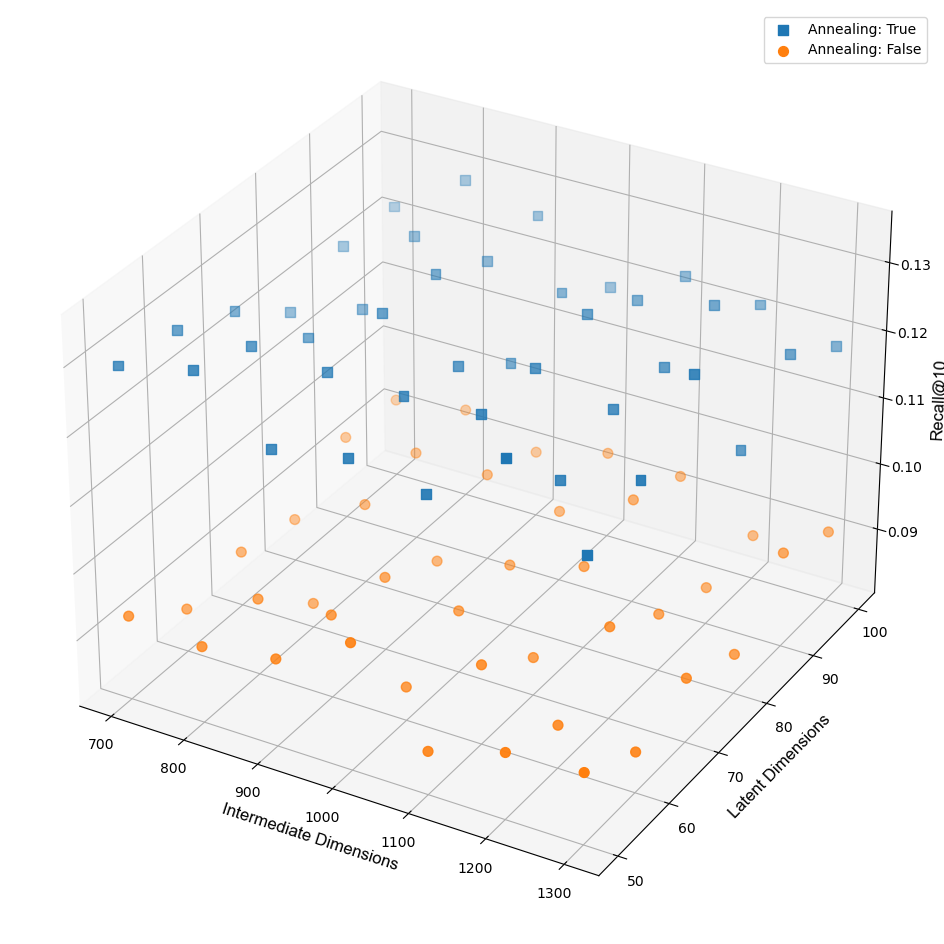

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 12))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x = df_tuning_2.intermediate_dimensions
y = df_tuning_2['latent_dimensions']
z = df_tuning_2['recall@10']
annealing = df_tuning_2['annealing']

ax.set_xlabel('Intermediate Dimensions', fontname='Arial', fontsize=12)
ax.set_ylabel('Latent Dimensions', fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10', fontname='Arial', fontsize=12)

# Define different marker shapes based on the annealing values
marker_shapes = ['o', 's'] 

# Iterate over unique annealing values and plot each separately
for annealing_value in annealing.unique():
    indices = annealing == annealing_value
    ax.scatter(
        x[indices],
        y[indices],
        z[indices],
        marker=marker_shapes[annealing_value],
        s=50,
        label=f'Annealing: {annealing_value}'
    )

# Add a legend
ax.legend()

plt.show()
